In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import re

In [2]:
domain_list = ["origin", "brightness", "contrast", "defocus_blur", "gaussian_noise", ]
checkitew_list = ["bottle", "cable", "capsule", "carpet", "grid", "hazelnut", "leather", "metal_nut", "pill", "screw", "tile", "toothbrush", "transistor", "wood", "zipper", ]
metric = "AUPRC"

dir_path = '../results/MVTEC/devnet/4domain'
dir_path = '../results/MVTEC/DGAD/method13_MVTEC'

dir_path = '../results/MVTEC/DGAD/method16'
# dir_path = '../results/MVTEC/DGAD/method16_severity5'
# dir_path = '../results/MVTEC/devnet/4domain_s5'
dir_path = '../results/MVTEC/devnet/4domain'

# dir_path = '../results/MVTEC/DGAD/method16_transistor'
dir_path = '../results/MVTEC/DGAD/method16_transistor_lambda'

In [3]:
import itertools
# normal_class=["0", "1", "2", "3", "4", "5", "6"]
# normal_class=["0 1 2 3", "4 5 6", "0 2 4 6", "1 3 5", "0", "1", "2", "3", "4", "5", "6"]
# anomaly_class=["4 5 6", "0 1 2 3", "1 3 5", "0 2 4 6", "1 2 3 4 5 6", "0 2 3 4 5 6", "0 1 3 4 5 6", "0 1 2 4 5 6", "0 1 2 3 5 6", "0 1 2 3 4 6", "0 1 2 3 4 5"]
# epochs_list=[5, 10, 15, 20, 30]
# lr_list=[0.01, 0.001, 0.0005, 0.0002, 0.00005, 0.00001]
reg_lambda=[1,2,5,10]
NCE_lambda=[1,2,5,10]
PL_lambda=[1,2,5,10]
# cnt=[0,1,2,3,4]
cnt=[0]
all_para_list = list(itertools.product(reg_lambda, NCE_lambda, PL_lambda, cnt))
print(len(all_para_list))
all_para_list[0]

64


(1, 1, 1, 0)

In [4]:
ans = []
# para_name_list=["checkitew", "pre_lr", "pre_epochs", "lr", "epochs", "cnt"]
# para_name_list=["checkitew", "lr", "epochs", "cnt", "tau1", "tau2"]
para_name_list=["checkitew", "lr", "epochs", "cnt",]
if dir_path.__contains__("lambda"):
    para_name_list=["checkitew", "lr", "epochs", "cnt", "reg_lambda", "NCE_lambda", "PL_lambda", "class_lambda"]
# para_name_list=["checkitew", "lr", "epochs", "cnt","reg_lambda"]
# para_name_list=["checkitew", "lr", "epochs", "cnt", "tau1", "tau2", "reg_lambda", "NCE_lambda", "PL_lambda"]
# para_name_list=["checkitew", "lr", "epochs", "cnt", "origin_svdd_lambda", "class_svdd_lambda", "align_lambda", "beta"]
print(len(os.listdir(dir_path)))
for file_name in os.listdir(dir_path):
    record = []
    data = np.load(f'{dir_path}/{file_name}', allow_pickle=True)
    max_epoch = data["val_max_metric"].item()["epoch"]
    # max_epoch = [i for i, val in enumerate(data[f"val_{metric}_list"]) if (val == max(data[f"val_{metric}_list"]))][-1]
    
    for key in para_name_list:
        if key in data["args"].item():
            record.append(data["args"].item()[key])
        else:
            record.append(1.0)
    
    record.append(max_epoch)

    if "metric" in data["val_max_metric"].item():
        for key in domain_list:
            record.append(0)
        for key in domain_list:
            record.append(0)
        for key in domain_list:
            record.append(data["val_max_metric"].item()["metric"][key]["AUROC"])
        for key in domain_list:
            record.append(data["val_max_metric"].item()["metric"][key]["AUPRC"])
    else:
        for key in domain_list:
            record.append(data["test_metric"].item()[key]["AUROC"])
        for key in domain_list:
            record.append(data["test_metric"].item()[key]["AUPRC"])
        for key in domain_list:
            record.append(data["test_results_list"][max_epoch][key]["AUROC"])
        for key in domain_list:
            record.append(data["test_results_list"][max_epoch][key]["AUPRC"])

    record.append(file_name)
    ans.append(record)

ans = pd.DataFrame(ans,columns=para_name_list + ["max_val_epoch"] +\
             [f'{item}_AUROC' for item in domain_list] + \
                [f'{item}_AUPRC' for item in domain_list] +\
                    [f'val_{item}_AUROC' for item in domain_list] +\
                        [f'val_{item}_AUPRC' for item in domain_list] + ["file_name"])

ans["checkitew"] = ans["checkitew"].astype(str)
ans["AUROC_mean"] = ans[[f'{item}_AUROC' for item in domain_list]].mean(axis = 1)
ans["AUPRC_mean"] = ans[[f'{item}_AUPRC' for item in domain_list]].mean(axis = 1)
ans["val_AUROC_mean"] = ans[[f'val_{item}_AUROC' for item in domain_list]].mean(axis = 1)
ans["val_AUPRC_mean"] = ans[[f'val_{item}_AUPRC' for item in domain_list]].mean(axis = 1)
ans["checkitew"] = ans["checkitew"].apply(lambda x :re.sub("\[|\]|,", "", x))
ans.head(5)

8


,checkitew,lr,epochs,cnt,reg_lambda,NCE_lambda,PL_lambda,class_lambda,max_val_epoch,origin_AUROC,...,val_origin_AUPRC,val_brightness_AUPRC,val_contrast_AUPRC,val_defocus_blur_AUPRC,val_gaussian_noise_AUPRC,file_name,AUROC_mean,AUPRC_mean,val_AUROC_mean,val_AUPRC_mean
0,transistor,0.00010,20,0,0.0,1.0,1.0,1.0,4,0,...,0.684501,0.766275,0.765476,0.722673,0.783153,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.0,0.0,0.782694,0.744416
1,transistor,0.00005,20,0,1.0,0.0,1.0,1.0,1,0,...,0.749595,0.852899,0.786999,0.714096,0.771965,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.0,0.0,0.812306,0.775111
2,transistor,0.00010,20,0,1.0,0.0,1.0,1.0,2,0,...,0.810607,0.892149,0.868168,0.816682,0.838014,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.0,0.0,0.868250,0.845124
3,transistor,0.00005,10,0,1.0,0.0,1.0,1.0,7,0,...,0.811549,0.879705,0.868423,0.826166,0.821233,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.0,0.0,0.871361,0.841415
4,transistor,0.00005,20,0,0.0,1.0,1.0,1.0,0,0,...,0.847915,0.804531,0.758260,0.763450,0.793426,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.0,0.0,0.829861,0.793516


In [5]:
ans["checkitew"].value_counts()

transistor    8
Name: checkitew, dtype: int64

In [6]:
ans = ans[ans["epochs"] != 2]
# if dir_path.__contains__("devnet"):
#     ans = ans[ans["lr"] != 0.00005]

In [7]:
ans.cnt.value_counts()

0    8
Name: cnt, dtype: int64

In [8]:
# pre_epochs_list = [10, 30, 50, 100]
# pre_lr_list = [0.01, 0.001, 0.0001]
# epochs_list = [10, 20, 30]
# lr_list = [0.00001, 0.0001, 0.001]
# cnt = [0, 1]
# all_para_list = list(itertools.product(cnt, pre_epochs_list, pre_lr_list, epochs_list, lr_list))
# remain_para = set(all_para_list) - set([tuple(item) for item in ans[["cnt", "pre_epochs", "pre_lr", "epochs", "lr"]].values])
# remain_para = pd.DataFrame(sorted(remain_para), columns=["cnt", "pre_epochs", "pre_lr", "epochs", "lr"])
# print(f"./{dir_path.split('/')[-1]}_remain_para.csv")
# # remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)
# remain_para

In [9]:
# remain_para = set(all_para_list) - set([tuple(item) for item in ans[(ans["epochs"]==30) & (ans["lr"]==0.00005) & (ans["cnt"] == 0)][["reg_lambda", "NCE_lambda", "PL_lambda", "cnt"]].values])
# remain_para = pd.DataFrame(remain_para, columns=["reg_lambda", "NCE_lambda", "PL_lambda", "cnt"])
# print(f"./{dir_path.split('/')[-1]}_remain_para.csv")
# remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)
# # remain_para
# len(remain_para)

In [10]:
# remain_para = set(all_para_list) - set([tuple(item) for item in ans[["normal_class", "epochs", "lr", "cnt"]].values])
# remain_para = pd.DataFrame(remain_para, columns=["normal_class", "epochs", "lr", "cnt"])
# remain_para.insert(1,"anomaly_class", remain_para.apply(lambda x: re.sub("\{|,|\}","", str(set([0,1,2,3,4,5,6]) - set(map(int, x["normal_class"].split(" "))))), axis=1))
# print(f"./{dir_path.split('/')[-1]}_remain_para.csv")
# remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)
# remain_para

In [11]:
if metric == "AUPRC":
    columns_to_drop = ans.filter(like='AUROC').columns.to_list()
    columns_to_drop.remove("val_AUROC_mean")
else:
    columns_to_drop = ans.filter(like='AUPRC').columns.to_list()
    columns_to_drop.remove("val_AUPRC_mean")
columns_to_drop = columns_to_drop + [f'{item}_{metric}' for item in domain_list] + [f"{metric}_mean"]
ans = ans.drop(columns=columns_to_drop) 
columns_to_drop

['origin_AUROC',
 'brightness_AUROC',
 'contrast_AUROC',
 'defocus_blur_AUROC',
 'gaussian_noise_AUROC',
 'val_origin_AUROC',
 'val_brightness_AUROC',
 'val_contrast_AUROC',
 'val_defocus_blur_AUROC',
 'val_gaussian_noise_AUROC',
 'AUROC_mean',
 'origin_AUPRC',
 'brightness_AUPRC',
 'contrast_AUPRC',
 'defocus_blur_AUPRC',
 'gaussian_noise_AUPRC',
 'AUPRC_mean']

In [12]:
# agg_method = {"cnt":["count"],
#               "max_val_epoch":["mean", "std"],
#               f"val_{metric}_mean":["mean", "std"],}
# for item in domain_list:
#     agg_method[f"val_{item}_{metric}"] = ["mean", "std"]

# pd.set_option("display.max_columns",None)
# pd.set_option("display.max_rows",None)
# total_avg = dict()
# for checkitew in checkitew_list:
#     checkitew = str(checkitew)
#     selected_records = ans[ans["checkitew"] == checkitew].drop(["checkitew"],axis=1)
#     # group_key = ["pre_lr", "pre_epochs", "lr", "epochs"]
#     group_key = list(set(para_name_list) - set(["checkitew", "cnt"]))
#     group_key.sort()
#     # print(group_key)
#     selected_records_anslysis = selected_records.groupby(group_key).agg(agg_method).sort_values(by=(f"val_{metric}_mean", "mean"), ascending=False)
#     selected_para = selected_records_anslysis.index[0]
#     # print(selected_para)
#     selected_records_anslysis

#     filter = None
#     for idx, item in enumerate(group_key):
#         if filter is None:
#             filter = selected_records[item] == selected_para[idx]
#         else:
#             filter = filter & (selected_records[item] == selected_para[idx])
#     temp = selected_records[filter].agg(["mean", "std"]).T
#     temp["res"] = temp.apply(lambda x: f'{round(x["mean"] *100, 2)}({round(x["std"] *100, 2)})', axis=1)
#     for key in [f'val_{item}_{metric}' for item in domain_list]:
#         print(temp.loc[key]["res"])
#         if key not in total_avg:
#             total_avg[key] = []
#         total_avg[key].append(temp.loc[key]["res"])
#     print(f'{round(selected_records_anslysis.loc[selected_para][f"val_{metric}_mean"]["mean"] * 100, 2)}({round(selected_records_anslysis.loc[selected_para][f"val_{metric}_mean"]["std"] * 100, 2)})')
#     selected_records[filter]

# total_domain_avg = []
# for key in [f'val_{item}_{metric}' for item in domain_list]:
#     value = total_avg[key]
#     total_domain_avg.append(round(np.array(list(map(lambda x: float(x.split("(")[0]), value))).mean(), 2))
#     print(total_domain_avg[-1])
# print(round(np.mean(total_domain_avg), 2))

In [13]:
# ans[(ans["normal_class"] == normal_class)].sort_values(by="val_AUROC_mean",ascending=False)

In [14]:
# remain_para = []
# for item in selected_records_anslysis.index[:10]:
#     remain_para.append(list(item))
# remain_para = pd.DataFrame(remain_para)
# remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)

In [15]:
# remain_para = []
# for item in selected_records_anslysis.index[:10]:
#     remain_para.append(["0","1 2 3 4 5 6",item[1],item[0],2])
#     remain_para.append(["0","1 2 3 4 5 6",item[1],item[0],3])
#     remain_para.append(["0","1 2 3 4 5 6",item[1],item[0],4])
    
# remain_para = pd.DataFrame(remain_para,columns=["normal_class", "anomaly_class", "epochs", "lr", "cnt"])
# # remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)
# remain_para

In [16]:
agg_method = {"cnt":["count"],
              "max_val_epoch":["mean", "std"]}
for item in domain_list:
    agg_method[f"val_{item}_{metric}"] = ["mean", "std"]

agg_method[f"val_{metric}_mean"] = ["mean", "std"]
agg_method[f"val_{metric}_mean"] = ["mean", "std"]

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
checkitew = 'transistor'
selected_records = ans[ans["checkitew"] == checkitew].drop(["checkitew"],axis=1)
# group_key = ["pre_lr", "pre_epochs", "lr", "epochs"]
group_key = list(set(para_name_list) - set(["checkitew", "cnt"]))
group_key.sort()
print(group_key)
selected_records_anslysis = selected_records.groupby(group_key).agg(agg_method).sort_values(by=(f"val_{metric}_mean", "mean"), ascending=False)
selected_para = selected_records_anslysis.index[0]
print(selected_para)
selected_records_anslysis

['NCE_lambda', 'PL_lambda', 'class_lambda', 'epochs', 'lr', 'reg_lambda']
(0.0, 1.0, 1.0, 20, 0.0001, 1.0)


cnt  \
                                                            count   
NCE_lambda PL_lambda class_lambda epochs lr      reg_lambda         
0.0        1.0       1.0          20     0.00010 1.0            1   
                                  10     0.00010 1.0            1   
                                         0.00005 1.0            1   
1.0        1.0       1.0          20     0.00005 0.0            1   
                                  10     0.00005 0.0            1   
0.0        1.0       1.0          20     0.00005 1.0            1   
1.0        1.0       1.0          20     0.00010 0.0            1   
                                  10     0.00010 0.0            1   

                                                            max_val_epoch      \
                                                                     mean std   
NCE_lambda PL_lambda class_lambda epochs lr      reg_lambda                     
0.0        1.0       1.0          20     0.00010 1.0                  2.0 NaN   
                                  10     0.00010 1.0                  3.0 NaN   
                                         0.00005 1.0                  7.0 NaN   
1.0        1.0       1.0          20     0.00005 0.0                  0.0 NaN   
                                  10     0.00005 0.0                  0.0 NaN   
0.0        1.0       1.0          20     0.00005 1.0                  1.0 NaN   
1.0        1.0       1.0          20     0.00010 0.0                  4.0 NaN   
                                  10     0.00010 0.0                  5.0 NaN   

                                                            val_origin_AUPRC  \
                                                                        mean   
NCE_lambda PL_lambda class_lambda epochs lr      reg_lambda                    
0.0        1.0       1.0          20     0.00010 1.0                0.810607   
                                  10     0.00010 1.0                0.821315   
                                         0.00005 1.0                0.811549   
1.0        1.0       1.0          20     0.00005 0.0                0.847915   
                                  10     0.00005 0.0                0.781760   
0.0        1.0       1.0          20     0.00005 1.0                0.749595   
1.0        1.0       1.0          20     0.00010 0.0                0.684501   
                                  10     0.00010 0.0                0.603487   

                                                                 \
                                                            std   
NCE_lambda PL_lambda class_lambda epochs lr      reg_lambda       
0.0        1.0       1.0          20     0.00010 1.0        NaN   
                                  10     0.00010 1.0        NaN   
                                         0.00005 1.0        NaN   
1.0        1.0       1.0          20     0.00005 0.0        NaN   
                                  10     0.00005 0.0        NaN   
0.0        1.0       1.0          20     0.00005 1.0        NaN   
1.0        1.0       1.0          20     0.00010 0.0        NaN   
                                  10     0.00010 0.0        NaN   

                                                            val_brightness_AUPRC  \
                                                                            mean   
NCE_lambda PL_lambda class_lambda epochs lr      reg_lambda                        
0.0        1.0       1.0          20     0.00010 1.0                    0.892149   
                                  10     0.00010 1.0                    0.834156   
                                         0.00005 1.0                    0.879705   
1.0        1.0       1.0          20     0.00005 0.0                    0.804531   
                                  10     0.00005 0.0                    0.807978   
0.0        1.0       1.0          20     0.00005 1.0                    0.852899   
1.0        1.0       1.0          2

In [17]:
filter = None
for idx, item in enumerate(group_key):
    if filter is None:
        filter = selected_records[item] == selected_para[idx]
    else:
        filter = filter & (selected_records[item] == selected_para[idx])
temp = selected_records[filter].agg(["mean", "std"]).T
temp["res"] = temp.apply(lambda x: f'{round(x["mean"] *100, 2)}({round(x["std"] *100, 2)})', axis=1)
for key in [f'val_{item}_{metric}' for item in domain_list]:
    print(temp.loc[key]["res"])
print(f'{round(selected_records_anslysis.loc[selected_para][f"val_{metric}_mean"]["mean"] * 100, 2)}({round(selected_records_anslysis.loc[selected_para][f"val_{metric}_mean"]["std"] * 100, 2)})')
selected_records[filter]

81.06(nan)
89.21(nan)
86.82(nan)
81.67(nan)
83.8(nan)
84.51(nan)


/tmp/ipykernel_104996/1079342940.py:7: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  temp = selected_records[filter].agg(["mean", "std"]).T


,lr,epochs,cnt,reg_lambda,NCE_lambda,PL_lambda,class_lambda,max_val_epoch,val_origin_AUPRC,val_brightness_AUPRC,val_contrast_AUPRC,val_defocus_blur_AUPRC,val_gaussian_noise_AUPRC,file_name,val_AUROC_mean,val_AUPRC_mean
2,0.0001,20,0,1.0,0.0,1.0,1.0,2,0.810607,0.892149,0.868168,0.816682,0.838014,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.86825,0.845124


In [18]:
file_name = selected_records[filter].file_name.iloc[0]
data = np.load(f'{dir_path}/{file_name}', allow_pickle=True)
data

NpzFile '../results/MVTEC/DGAD/method16_transistor_lambda/method=16,backbone=DGAD15,domain_cnt=4,checkitew=transistor,batch_size=30,steps_per_epoch=20,epochs=20,lr=0.0001,reg_lambda=1.0,NCE_lambda=0.0,PL_lambda=1.0,cnt=0.npz' with keys: val_max_metric, train_results_loss, sub_train_results_loss, val_results_loss, val_AUROC_list...

In [19]:
# # data = np.load(f'{dir_path}/{file_name}', allow_pickle=True)
# file_name = 'results/DEBUG/method=10,backbone=DGAD9,domain_cnt=3,normal_class=[0],anomaly_class=[1, 2, 3, 4, 5, 6],batch_size=30,steps_per_epoch=20,epochs=40,lr=5e-05,tau1=0.07,tau2=0.07,origin_svdd_lambda=1.0,class_svdd_lambda=1.0,align_lambda=1.0,beta=0.9,cnt=0.npz'
# data = np.load(f'../{file_name}', allow_pickle=True)
# data

In [20]:
domain_test_trends = dict()
for domain in domain_list:
    domain_test_trends[domain]={
        "test_loss_list":[],
        "AUROC":[],
        "AUPRC":[],
    }

domain_test_trends
for res in data["test_results_list"]:
    if res is not None:
        for key in res:
            domain_test_trends[key]["test_loss_list"].append(np.array(res[key]["test_loss_list"]).mean())
            domain_test_trends[key]["AUROC"].append(res[key]["AUROC"])
            domain_test_trends[key]["AUPRC"].append(res[key]["AUPRC"])

### 训练过程中 模型在test上下降趋势

2
origin [0.7681679626023072, 0.5178291245711792, 0.4840221065359166, 0.45953687928811704, 0.47880922777345913]
brightness [0.8807189875453, 0.48468285880456696, 0.5201935010731127, 0.444903580023689, 0.48503953194411836]
contrast [0.7362880015438557, 0.7510558987858886, 0.816113764221476, 0.7462675799076621, 0.811479724934146]
defocus_blur [0.693829018541658, 0.5862032665883208, 0.5070014211642393, 0.49598673155837225, 0.4998186254331529]
gaussian_noise [0.8116051390564445, 0.8481074287891185, 0.8624334428836595, 0.864774020763608, 0.8634635738899343]


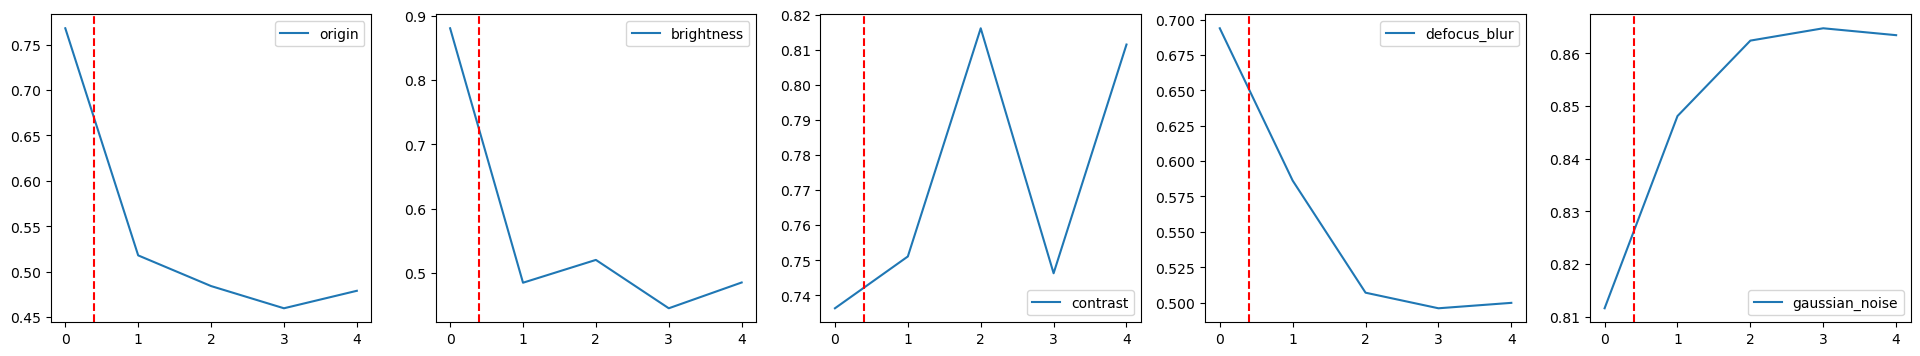

2
origin 0.8106071931642014
brightness 0.8921487899219664
contrast 0.868168042624154
defocus_blur 0.8166815581875697
gaussian_noise 0.838014433990634


In [21]:
max_val_epoch = data["val_max_metric"].item()['epoch']
print(max_val_epoch)

fig, ax = plt.subplots(1,5, figsize=(24, 4))

for idx, domain in enumerate(domain_list):
    ax[idx].plot(domain_test_trends[domain][metric], label = domain)
    print(domain, domain_test_trends[domain][metric])

    if "metric" in data["val_max_metric"].item():
        if "test_epoch" in data["args"].item():
            ax[idx].axvline(x=max_val_epoch / data["args"].item()["test_epoch"], color='r', linestyle='--')
        else:
            ax[idx].axvline(x=max_val_epoch / 5, color='r', linestyle='--')
    else:
        ax[idx].axvline(x=max_val_epoch, color='r', linestyle='--')

    ax[idx].legend()
plt.show()

print(max_val_epoch)
if "metric" in data["val_max_metric"].item():
    for domain in domain_list:
        print(domain, data["val_max_metric"].item()["metric"][domain][metric])
else:
    for domain in domain_list:
        print(domain, domain_test_trends[domain][metric][max_val_epoch])

In [22]:
file_name = selected_records[filter].file_name.iloc[0]
data = np.load(f'{dir_path}/{file_name}', allow_pickle=True)
data

domain_test_trends = dict()
for domain in domain_list:
    domain_test_trends[domain]={
        "test_loss_list":[],
        "AUROC":[],
        "AUPRC":[],
    }

domain_test_trends
for res in data["test_results_list"]:
    if res is not None:
        for key in res:
            domain_test_trends[key]["test_loss_list"].append(np.array(res[key]["test_loss_list"]).mean())
            domain_test_trends[key]["AUROC"].append(res[key]["AUROC"])
            domain_test_trends[key]["AUPRC"].append(res[key]["AUPRC"])

tmp = []
for idx, domain in enumerate(domain_list):
    tmp.append(domain_test_trends[domain][metric])
tmp = pd.DataFrame(tmp, index=domain_list)
idx = tmp.mean(axis = 0).idxmax()
print(idx)
pd.concat([tmp, pd.DataFrame(tmp.mean(axis = 0), columns = ["avg"]).T])

0


,0,1,2,3,4
origin,0.768168,0.517829,0.484022,0.459537,0.478809
brightness,0.880719,0.484683,0.520194,0.444904,0.485040
contrast,0.736288,0.751056,0.816114,0.746268,0.811480
defocus_blur,0.693829,0.586203,0.507001,0.495987,0.499819
gaussian_noise,0.811605,0.848107,0.862433,0.864774,0.863464
avg,0.778122,0.637576,0.637953,0.602294,0.627722


### 训练集loss下降趋势

array([ 3.03295059,  0.69035599,  0.11147275, -0.41497855, -0.62666917,
       -0.63131337, -0.68612428, -0.66001956, -0.67916248, -0.72237633,
       -0.69631459, -0.70562918, -0.71980367, -0.71196533, -0.72739562,
       -0.7190778 , -0.71828075, -0.71691096, -0.72010431, -0.71497692])

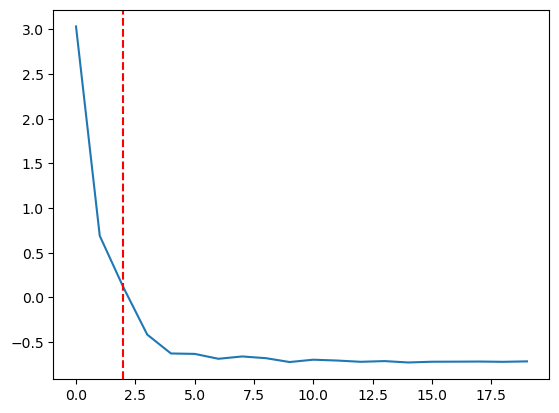

In [23]:
plt.plot(data["train_results_loss"].mean(axis=1)[0:])
plt.axvline(x=max_val_epoch, color='r', linestyle='--')
data["train_results_loss"].mean(axis=1)

### 训练过程中，模型在val 下降趋势

#### 验证集loss下降趋势

array([0.20467364, 0.14719966, 0.1527872 , 0.14928192, 0.14223654,
       0.14581763, 0.14657867, 0.13947357, 0.1414294 , 0.14444585,
       0.14732058, 0.1447689 , 0.1445562 , 0.14538712, 0.14193772,
       0.14261937, 0.14544506, 0.14074127, 0.14029451, 0.14127666])

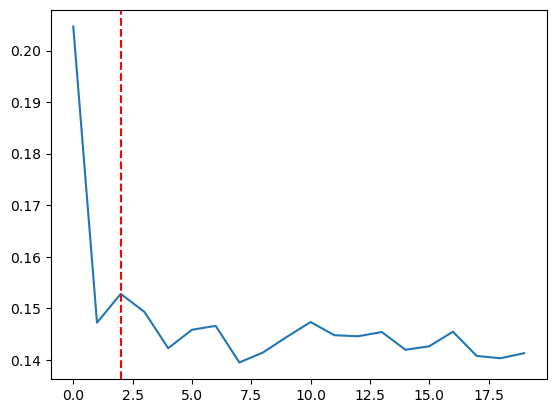

In [24]:
plt.plot(data["val_results_loss"].mean(axis=1))
plt.axvline(x=max_val_epoch, color='r', linestyle='--')
data["val_results_loss"].mean(axis=1)

#### 验证集AUROC

array([0.60380117, 0.60672515, 0.86988304, 0.21491228, 0.21052632,
       0.24707602, 0.15643275, 0.20906433, 0.27923977, 0.28508772,
       0.2997076 , 0.31140351, 0.28947368, 0.26023392, 0.25292398,
       0.25877193, 0.2748538 , 0.26754386, 0.26608187, 0.27339181])

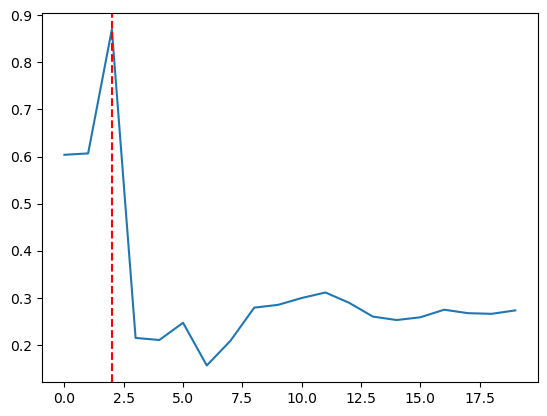

In [25]:
plt.plot(data[f"val_AUROC_list"])
plt.axvline(x=max_val_epoch, color='r', linestyle='--')
# plt.ylim(0.5,1)
data[f"val_AUROC_list"]

array([0.03370464, 0.0728755 , 0.09566084, 0.01769935, 0.01742521,
       0.01835743, 0.01651215, 0.01735632, 0.01903458, 0.01916181,
       0.01945607, 0.01970929, 0.01921887, 0.01863942, 0.01845504,
       0.01853026, 0.01892619, 0.01882028, 0.01871015, 0.01891213])

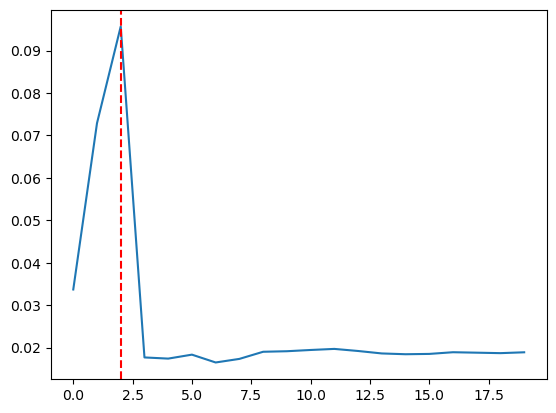

In [26]:
plt.plot(data[f"val_{metric}_list"])
plt.axvline(x=max_val_epoch, color='r', linestyle='--')
# plt.ylim(0.5,1)
data[f"val_{metric}_list"]

[2.40850277 2.01422026 1.43487723 0.86789859 0.69945551 0.69432644
 0.6741238  0.69537359 0.67611547 0.63629352 0.66271604 0.66774109
 0.65448838 0.65929018 0.64228403 0.65498919 0.64816275 0.6624862
 0.65310729 0.66122993]


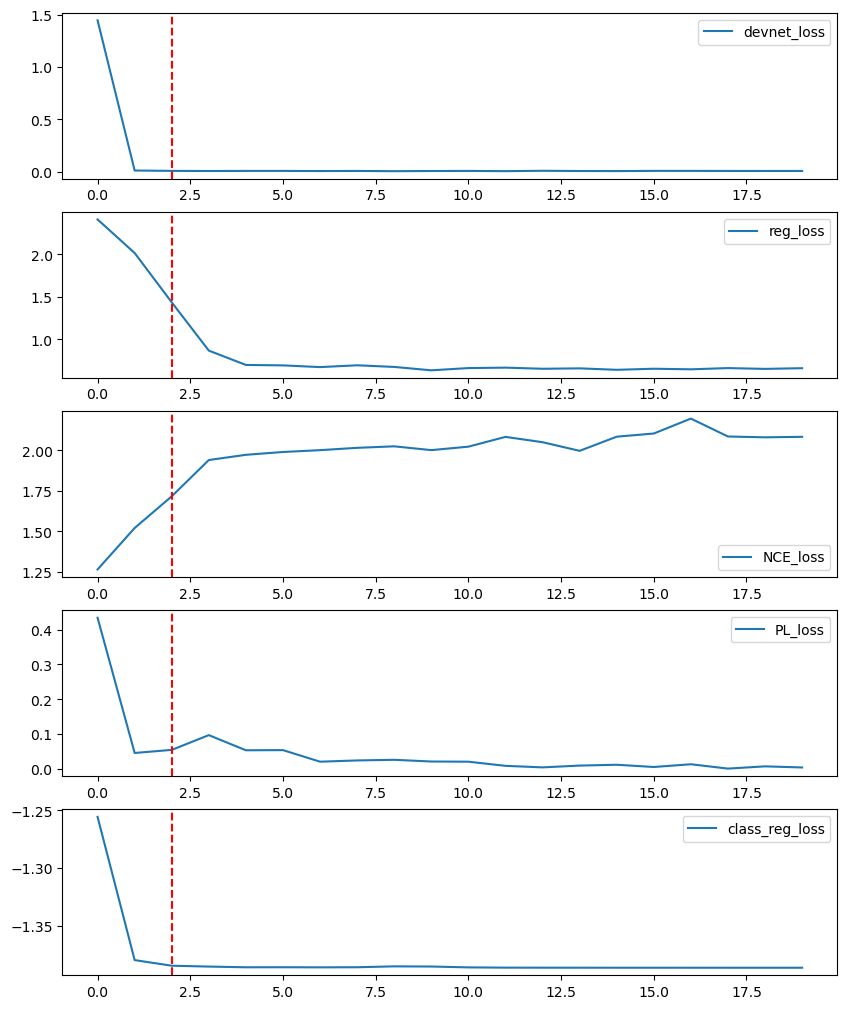

In [27]:
temp = data["sub_train_results_loss"].mean(axis=1)
fig,ax = plt.subplots(temp.shape[1],1,figsize=(10,2.5 * temp.shape[1]))
if dir_path.__contains__("method13"):
    loss_name_list = ["devnet_loss", "reg_loss", "NCE_loss", "PL_loss", "class_reg_loss"]
elif dir_path.__contains__("VAE_LPIPS_DEVNET"):
    loss_name_list = ["rec_loss", "kl_loss", "devnet_loss", "reg_loss", "PL_loss", "class_reg_loss"]
else:
    loss_name_list = ["devnet_loss", "reg_loss", "NCE_loss", "PL_loss", "class_reg_loss"]
for idx, label in enumerate(loss_name_list):
    ax[idx].plot(temp[0:,idx], label=label)
    ax[idx].axvline(x=max_val_epoch, color='r', linestyle='--')
    ax[idx].legend()

# for i in range(5):
#     print(temp[0:,i])
print(temp[0:, 1])
plt.show()

In [28]:
temp[0:, 0][-5]

0.0065028224023990335

In [29]:
# data["sub_train_results_loss"].mean(axis=1)

In [30]:
if "pre_epochs" in para_name_list:
    temp = []
    for item in file_name.split(","):
        if re.match("epochs=|lr=|reg_lambda", item):
            pass
        else:
            temp.append(item)
    data = np.load(f'../experiment/{",".join(temp)}', allow_pickle=True)

In [31]:
plt.plot(data["pre_train_results_loss"].mean(axis=1))

KeyError: 'pre_train_results_loss is not a file in the archive'

In [ ]:
temp = data["sub_pre_train_results_loss"].mean(axis=1)
fig,ax = plt.subplots(2,1,figsize=(6, 6))
ax[0].plot(temp[0:,0], label="NCE_loss")
ax[1].plot(temp[0:,1], label="PL_loss") 
ax[0].legend()
ax[1].legend()
plt.show()

KeyError: 'sub_pre_train_results_loss is not a file in the archive'

In [ ]:
temp[0:,0]

array([5.12366613e-02, 7.52512779e-04, 2.38156579e-04, 1.11763124e-04,
       9.64891620e-05, 7.81198205e-05, 7.47454518e-05, 6.63250018e-05,
       5.95974552e-05, 5.38587965e-05, 5.10202187e-05, 4.65418390e-05,
       4.23788977e-05, 4.13187449e-05, 4.01404671e-05, 3.87827890e-05,
       3.81627700e-05, 3.65760899e-05, 3.56698465e-05, 3.59697684e-05,
       3.47524817e-05, 3.46994501e-05, 3.51303973e-05, 3.37718926e-05,
       3.41283220e-05, 3.38422307e-05, 3.38356650e-05, 3.35584650e-05,
       3.30837758e-05, 3.34783733e-05])

In [ ]:
temp[0:,1]

array([4.97540535e-01, 1.41077568e-01, 2.41149376e-02, 4.21630200e-02,
       5.27702281e-02, 4.10839084e-02, 4.46073550e-02, 3.27919084e-03,
       1.01064351e-03, 1.06021749e-04, 5.06643846e-05, 2.74663981e-05,
       2.02918835e-05, 1.68948272e-05, 1.48062682e-05, 1.33578818e-05,
       1.22908901e-05, 1.14740167e-05, 1.08376776e-05, 1.03394184e-05,
       9.94086144e-06, 9.62827937e-06, 9.38167218e-06, 9.19360803e-06,
       9.04976189e-06, 8.94778285e-06, 8.87626526e-06, 8.83177576e-06,
       8.80642324e-06, 8.79488158e-06])